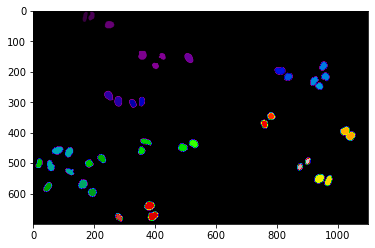

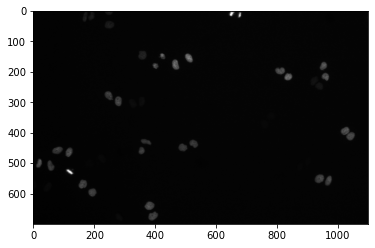

In [3]:
from glob import glob
from PIL import Image
from natsort import natsorted
import matplotlib.pyplot as plt
import os
from skimage.exposure import match_histograms
import numpy as np

image_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/01','*.tif')))
mask_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/01_ST/SEG','*.tif')))

plt.figure()
plt.imshow(np.array(Image.open(mask_paths[2])), cmap=plt.nipy_spectral())
plt.show()

plt.figure()
plt.imshow(np.array(Image.open(image_paths[2])), cmap='gray')
plt.show()

In [4]:
print(np.shape(np.array(Image.open(mask_paths[2]))))
print(np.shape(np.array(Image.open(image_paths[2]))))

(700, 1100)
(700, 1100)


In [5]:
from skimage import exposure, img_as_ubyte


def rescale_image(image, bit_depth):
    """
    Rescales the image based on its bit depth.
    """
    return image / (2 ** bit_depth)

def percentile_normalization(img, lower_percentile, upper_percentile):
    img_array = np.array(img)
    lower_bound = np.percentile(img_array, lower_percentile)
    upper_bound = np.percentile(img_array, upper_percentile)

    # Clip the values to the bounds set by the percentiles
    clipped_img_array = np.clip(img_array, lower_bound, upper_bound)

    # Scale the values to be in the range [0, 255]
    normalized_img_array = ((clipped_img_array - lower_bound) / (upper_bound - lower_bound) * 255).astype(np.uint8)

    # Convert the array back to an image
    normalized_img = Image.fromarray(normalized_img_array)
    return normalized_img

# Function to apply rotations and save images
def process_and_save_images(ref_path, image_paths, mask_paths, images_folder, masks_folder):
    angles = [0, 180]

    reference_image = np.array(Image.open(ref_path))
    
    # Rescaling the cell image
    reference_image = exposure.rescale_intensity(reference_image, out_range=np.uint16)

    # Converting the cell image to 8bit representation
    reference_image = img_as_ubyte(reference_image)

    for img_path, mask_path in zip(image_paths, mask_paths):
        img = Image.open(img_path)
        
        # Rescaling the cell image
        img = exposure.rescale_intensity(np.array(img), out_range=np.uint16)

        # Converting the cell image to 8bit representation
        rescaled_16bit = rescale_image(img, 16)

        # img = match_histograms(np.array(img), reference_image)
        img = Image.fromarray((rescaled_16bit).astype(np.float32)) 
        mask = Image.open(mask_path)
        img_name = os.path.splitext(os.path.basename(img_path))[0]
        mask_name = os.path.splitext(os.path.basename(mask_path))[0]

        for angle in angles:
            rotated_img = img.rotate(angle)
            rotated_mask = mask.rotate(angle)
            rotated_img.save(os.path.join(images_folder, f'{img_name}_rot{angle}.tif'))
            rotated_mask.save(os.path.join(masks_folder, f'{mask_name}_rot{angle}.tif'))

            # For the flipped versions
            flipped_img = rotated_img.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_mask = rotated_mask.transpose(Image.FLIP_LEFT_RIGHT)
            flipped_img.save(os.path.join(images_folder, f'{img_name}_rot{angle}_flipped.tif'))
            flipped_mask.save(os.path.join(masks_folder, f'{mask_name}_rot{angle}_flipped.tif'))

In [6]:
# Assume you have a list of image paths and mask paths like this:
image_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/01','*.tif')))
mask_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/01_ST/SEG','*.tif')))

# Def ref image for hist matching
ref_path = image_paths[0]

# Calculate the split index for 80% training, 20% validation
split_index = int(0.8 * len(image_paths))

# Shuffle the data before splitting (optional)
# Create a combined list of pairs and shuffle them
combined = list(zip(image_paths, mask_paths))
np.random.shuffle(combined)
image_paths[:], mask_paths[:] = zip(*combined)

# Split the data
train_image_paths = image_paths[:split_index]
train_mask_paths = mask_paths[:split_index]
val_image_paths = image_paths[split_index:]
val_mask_paths = mask_paths[split_index:]

# Directories for the datasets
base_folder = './dataset'
train_images_folder = os.path.join(base_folder, 'train/images')
train_masks_folder = os.path.join(base_folder, 'train/masks')
val_images_folder = os.path.join(base_folder, 'val/images')
val_masks_folder = os.path.join(base_folder, 'val/masks')

# Create the directories
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_masks_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_masks_folder, exist_ok=True)

# Process and save the training images and masks
process_and_save_images(ref_path, train_image_paths, train_mask_paths, train_images_folder, train_masks_folder)

# Process and save the validation images and masks
process_and_save_images(ref_path, val_image_paths, val_mask_paths, val_images_folder, val_masks_folder)


In [7]:
test_image_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/02','*.tif')))
test_mask_paths = natsorted(glob(os.path.join('./dataset/Fluo-N2DL-HeLa/02_ST/SEG','*.tif')))

# The directory where you want to save the new images
test_images_folder = os.path.join(base_folder, 'test/images')
test_masks_folder = os.path.join(base_folder, 'test/masks')

# Create the directories
os.makedirs(test_images_folder, exist_ok=True)
os.makedirs(test_masks_folder, exist_ok=True)

reference_image = np.array(Image.open(ref_path))

# Rescaling the cell image
reference_image = exposure.rescale_intensity(reference_image, out_range=np.uint16)

# Converting the cell image to 8bit representation
reference_image = img_as_ubyte(reference_image)

# Process and save the validation images
for img_path, mask_path in zip(test_image_paths, test_mask_paths):
    img = Image.open(img_path)

    # Rescaling the cell image
    img = exposure.rescale_intensity(np.array(img), out_range=np.uint16)

    # Converting the cell image to 8bit representation
    rescaled_16bit = rescale_image(img, 16)

    # img = match_histograms(np.array(img), reference_image)
    img = Image.fromarray((rescaled_16bit).astype(np.float32)) 

    mask = Image.open(mask_path)
    img_name = os.path.splitext(os.path.basename(img_path))[0]
    mask_name = os.path.splitext(os.path.basename(mask_path))[0]

    img.save(os.path.join(test_images_folder, f'{img_name}.tif'))
    mask.save(os.path.join(test_masks_folder, f'{mask_name}.tif'))

       